<a href="https://colab.research.google.com/github/decomiteA/ReachRLToolbox/blob/main/TestRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reaching movement using Reinforcement Learning agents 
## Part 1 : Feasibility study - Q-learning

**Author** : Antoine De Comite

The goal of this notebook is to investigate the feasibility of modelling human reaching movements using reinforcement learning algorithms. This notebook will focus on the q-learning algorithm.

The following problems will assess the feasibility of the following:

* Target redundancy (large versus narrow target)
* Target reward 
* Multiple targets
* Multiple targets with different rewards

For each of these task, we will compare the observed behaviour of the toy model with experimental evidences. It's worth noting that the environment used in this notebook is an oversimplification of reaching movements and the RL agent won't therefore have the ability to reproduce complex behviour. This will hopefully happen in the follow up notebooks. 

In [1]:
#@title Imports

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import convolve as conv


In [9]:
#@title Plot handling

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')

def plot_quiver_max_action(env,value,ax=None):
  """
  Generate plot showing action of maximum value or maximum probability for each state
  """
  if ax is None: 
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x),[env.dim_y,1])+0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis],[1,env.dim_x])
  which_max = np.reshape(value.argmax(axis=1),(env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(Y.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X,Y,U,V)
  ax.set(
      title='Maximum value/probability actions',
      xlim = [-0.5, env.dim_x+0.5],
      ylim = [-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')

  
def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0])
  #plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1])
  #im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  #fig.colorbar(im)


def plot_behavior():
  return

##Some generic functions...

In [3]:
#@title Different learning rules

def q_learning(state,action,reward,next_state,value,params):
  """
  This function implements the q-learning algorithm
  """
  q=value[state,action]
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])
  
  #compute td error
  td_error = reward + params['gamma']*max_next_q-q

  #update q value
  value[state,action] = q+params['alpha']*td_error
  return value

In [4]:
#@title Policies 

def epsilon_greedy(q,epsilon):
  """
  This function implements the epsilong greedy policy
  """
  if np.random.random()>epsilon:
    action=np.argmax(q)
  else:
    action=np.random.choice(len(q))
  
  return action

def greedy(q):
  """
  This function implements the greedy (aka optimal policy)
  """
  return np.argmax(q)

In [16]:
#@title Learning the environment

def learn_environment(env,learning_rule,params,max_steps,n_episodes):
  """
  This function learns the environment that the agent interacts with
  """
  value = np.ones((env.n_states,env.n_actions)) # initialize the qfunction

  reward_sums = np.zeros(n_episodes) # this table will contains the total reward of each episode

  # loop over the episodes
  for episode in range(n_episodes):
    state=env.init_state
    reward_sum=0
    for t in range(max_steps):
      #choose next action
      action = epsilon_greedy(value[state],params['epsilon'])
      #observe outcome of action on environment
      next_state, reward = env.get_outcome(state,action)
      #update value function
      value = learning_rule(state,action,reward,next_state,value,params)
      #sum rewards obtained
      reward_sum +=reward

      if next_state is None:
        reward_sum += 0
        break
      state = next_state
  
    reward_sums[episode] = reward_sum

  return value, reward_sums

def simulate_episode(value,env,params,max_steps):
  state_history=np.zeros(max_steps)
  state=env.init_state
  state_history[0] = state
  reward_sum=0
  for t in range(max_steps):
    action = epsilon_greedy(value[state],params['epsilon'])
    next_state,reward=env.get_outcome(state,action)
    reward_sum += reward  

    if next_state is None:
      reward_sum +=0
      break
    state_history[t+1]=next_state
    state=next_state

  return state_history,reward_sum  

def simulate_behavior(value,env,params,max_steps):
  """
  This function simulates the asymptotical behavior
  """
  state_history = np.zeros(max_steps)
  state=env.init_state
  state_history[0] = state
  reward_sum=0
  for t in range(max_steps):
    action=greedy(value[state])
    next_state,reward=env.get_outcome(state,action)
    reward_sum += reward

    if next_state is None:
      reward_sum += 0
      break
    state_history[t+1]=next_state
    state=next_state

  return state_history, reward_sum


#Part 1: Grid world - Simple reaching
This section implements a grid world of 5x10 squares to represent simple reaching movements to a narrow target.

In [6]:
class SimpleGrid:
  """
  This class defines the simple grid world that consists of a 5x10 grid with a single target state. The home target is state 3 and goal target is state 48
  """

  def __init__(self):
    self.name="SimpleGrid"
    self.n_states=50
    self.n_actions=4
    self.dim_x=5
    self.dim_y=10
    self.init_state=3

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if state==47:
      reward=0
      next_state=None
      return next_state,reward

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%5==4: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>44:
        next_state=state
      else:
        next_state=state+5
      
    elif action==2: #move left
      if state%5==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<5:
        next_state=state
      else:
        next_state=state-5
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes


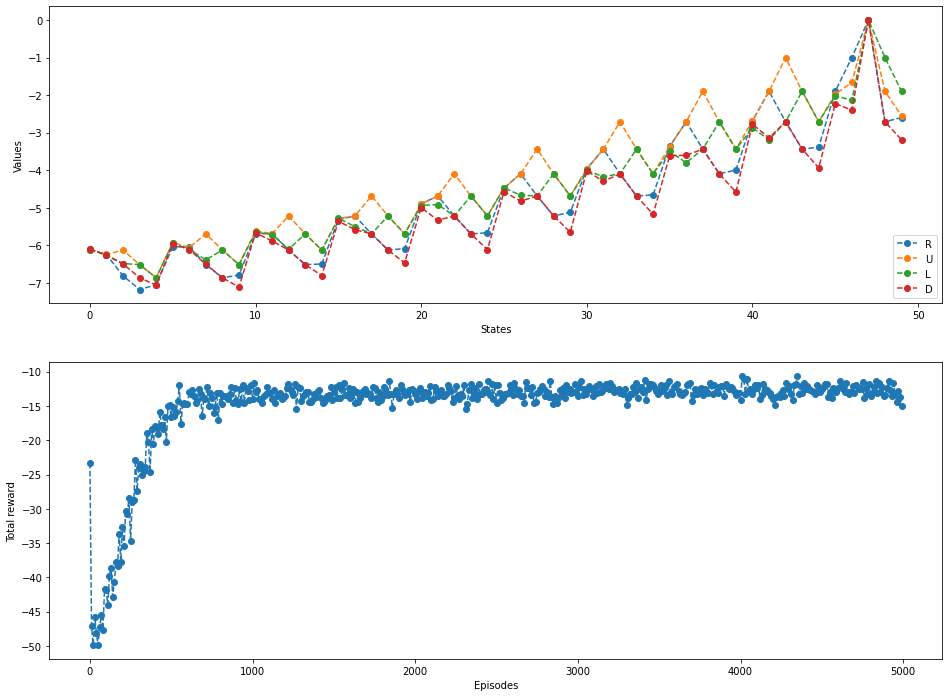

In [17]:
params = {
    'epsilon':0.2,
    'alpha':0.1,
    'gamma':0.9,
}

env_test = SimpleGrid()
n_episodes = 5000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
# print(value_qlearning)


state_history,reward_sum = simulate_episode(value_qlearning,env_test,params,max_steps)
# print(state_history)
state_behav,reward_behav = simulate_behavior(value_qlearning,env_test,params,max_steps)

In [18]:
print(state_behav)

[ 3.  8. 13. 18. 23. 28. 33. 38. 43. 48. 47.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


# Part 2 : Grid world - Target redundancy 

In [13]:
class Redundancy:
  """
  This class defines the simple grid world that consists of a 5x10 grid with three target states mimicking target redundancy. The home target is state 3 and goal target states are [46 47 48]
  """

  def __init__(self):
    self.name="SimpleGrid"
    self.n_states=50
    self.n_actions=4
    self.dim_x=5
    self.dim_y=10
    self.init_state=3

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if (state==46 or state==47 or state==48):
      reward=0
      next_state=None
      return next_state,reward

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%5==4: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>44:
        next_state=state
      else:
        next_state=state+5
      
    elif action==2: #move left
      if state%5==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<5:
        next_state=state
      else:
        next_state=state-5
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes


[ 3.  8. 13. 18. 23. 28. 33. 38. 43. 48.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


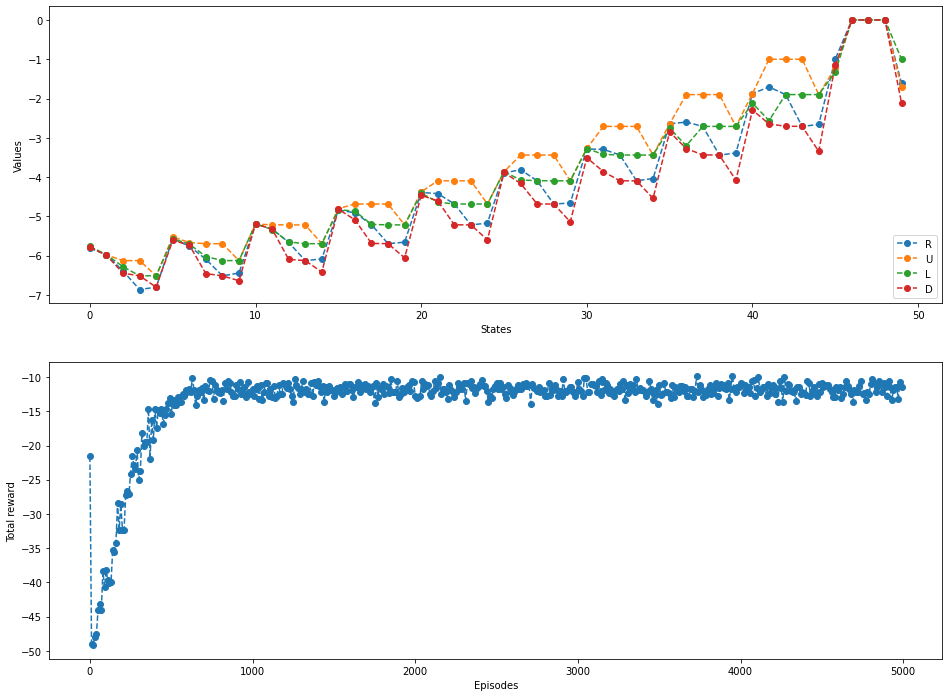

In [26]:
params = {
    'epsilon':0.2,
    'alpha':0.1,
    'gamma':0.9,
}

env_test = Redundancy()
n_episodes = 5000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
# print(value_qlearning)

state_history,reward_sum = simulate_episode(value_qlearning,env_test,params,max_steps)
print(state_history)

##Part 3 : Gridworld - Multiple targets 

In [27]:
class MultipleTargets:
  """
  This class defines the simple grid world that consists of a 5x10 grid with two different targets states at position 45 and 48.
  """

  def __init__(self):
    self.name="SimpleGrid"
    self.n_states=50
    self.n_actions=4
    self.dim_x=5
    self.dim_y=10
    self.init_state=3

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if (state==45 or state==49):
      reward=0
      next_state=None
      return next_state,reward

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%5==4: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>44:
        next_state=state
      else:
        next_state=state+5
      
    elif action==2: #move left
      if state%5==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<5:
        next_state=state
      else:
        next_state=state-5
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes


[ 3.  4.  9. 14. 19. 24. 19. 24. 23. 22. 27. 32. 37. 38. 39. 44. 49.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


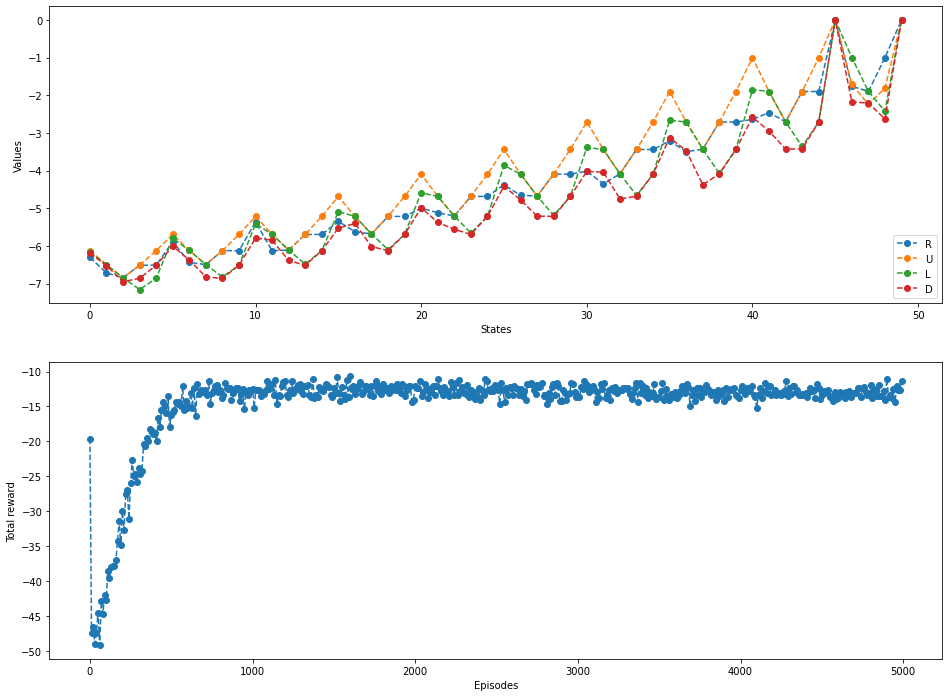

In [42]:
params = {
    'epsilon':0.2,
    'alpha':0.1,
    'gamma':0.9,
}

env_test = MultipleTargets()
n_episodes = 5000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
# print(value_qlearning)

state_history,reward_sum = simulate_episode(value_qlearning,env_test,params,max_steps)
print(state_history)

## Part 4 : Gridworld - Obstacles implementation

In [43]:
class Obstacles:
  """
  This class defines the simple grid world that consists of a 5x10 grid with a single target state and obstacles located in the way.
  """

  def __init__(self):
    self.name="SimpleGrid"
    self.n_states=50
    self.n_actions=4
    self.dim_x=5
    self.dim_y=10
    self.init_state=3

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if state==47:
      reward=0
      next_state=None
      return next_state,reward

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%5==4: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>44:
        next_state=state
      else:
        next_state=state+5
      
    elif action==2: #move left
      if state%5==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<5:
        next_state=state
      else:
        next_state=state-5
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    if (state==31 or state==33):
      reward = -1
      next_state=state  
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes


[ 3.  8. 13. 12. 17. 22. 27. 32. 37. 42. 47.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


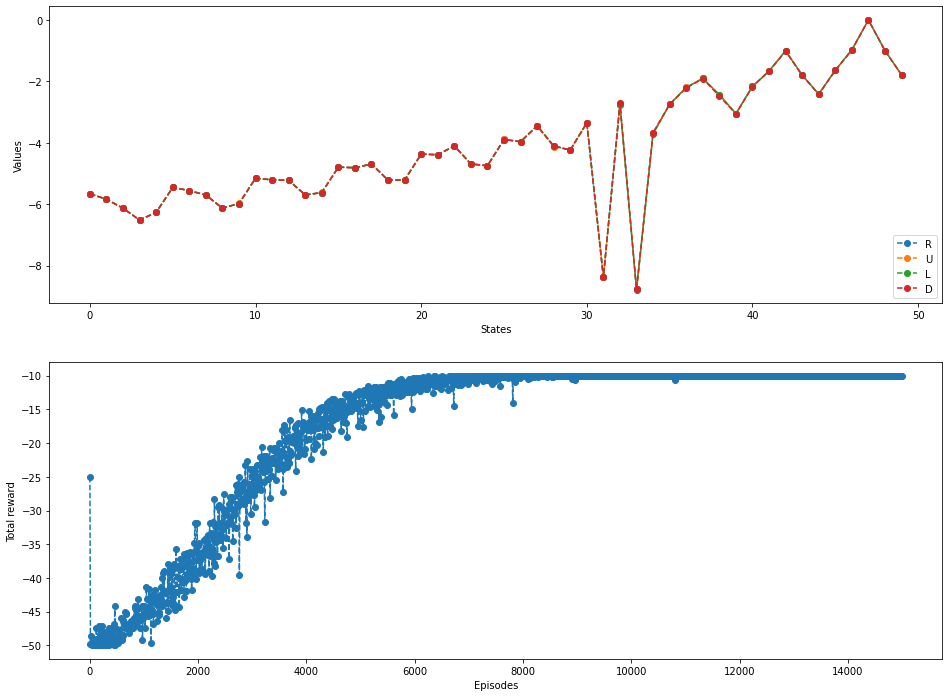

In [44]:
params = {
    'epsilon':0,
    'alpha':0.01,
    'gamma':0.9,
}

env_test = Obstacles()
n_episodes = 15000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
# print(value_qlearning)

state_history,reward_sum = simulate_episode(value_qlearning,env_test,params,max_steps)
print(state_history)

##Part 5: Gridworld - Multiple targets with different rewards

In [ ]:
class MultipleTargetsRewards:
  """
  This class defines the simple grid world that consists of a 5x10 grid with two target states located at two edges of the grid and associated with different rewards
  """

  def __init__(self):
    self.name="SimpleGrid"
    self.n_states=50
    self.n_actions=4
    self.dim_x=5
    self.dim_y=10
    self.init_state=3

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if state==45:
      reward=0
      next_state=None
    elif state==49:
      reward=0.2
      next_state=None
      return next_state,reward

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%5==4: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>44:
        next_state=state
      else:
        next_state=state+5
      
    elif action==2: #move left
      if state%5==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<5:
        next_state=state
      else:
        next_state=state-5
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes


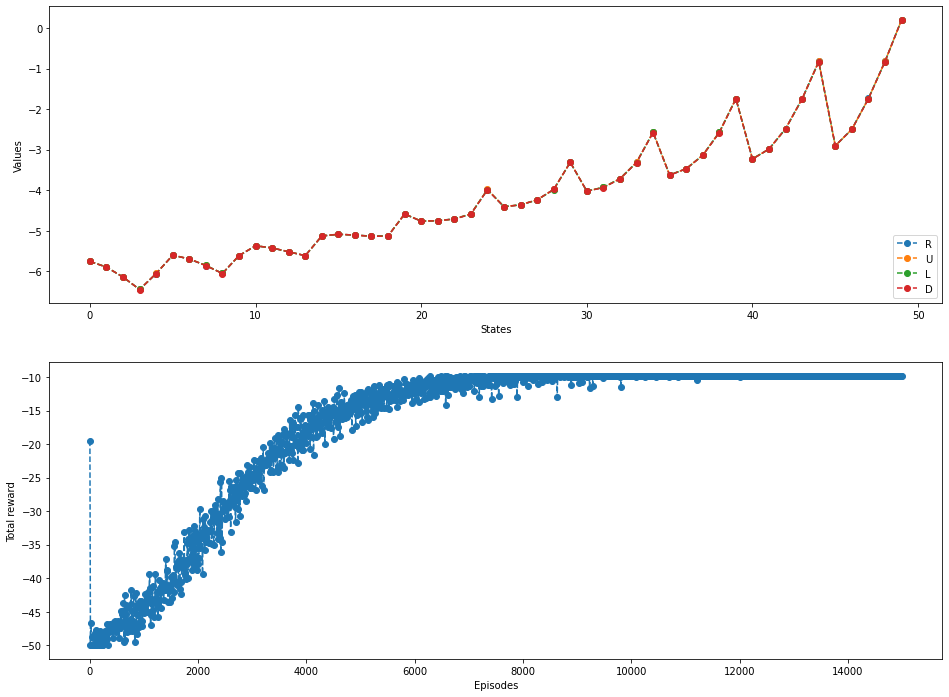

In [ ]:
params = {
    'epsilon':0,
    'alpha':0.01,
    'gamma':0.9,
}

env_test = MultipleTargetsRewards()
n_episodes = 15000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
# print(value_qlearning)

state_history,reward_sum = simulate_episode(value_qlearning,env_test,params,max_steps)
# print(state_history)